In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import galsim

Train from a random sampling of 50 points in 3 Zernikes (defocus, astig1, astig2) with magnitudes between -0.1 and +0.1.

In [2]:
aberrations = (np.random.uniform(size=(50,3)) - 0.5) * 0.2

Next draw the PSFs corresponding to these Zernikes

In [3]:
PSFs = [galsim.OpticalPSF(lam=700, diam=8.4, obscuration=0.5, aberrations=np.concatenate([[0]*4, a])) for a in aberrations]
PSFims = [PSF.drawImage(nx=32, ny=32, scale=0.005) for PSF in PSFs]

/Users/josh/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


Draw a few of the PSFs.

/Users/josh/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


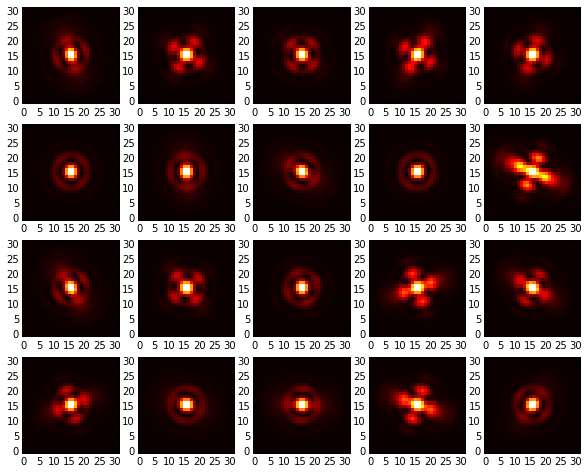

In [4]:
fig = plt.figure(figsize=(10,8))
for i in range(20):
    ax = fig.add_subplot(4,5,i+1)
    ax.imshow(PSFims[i].array)
fig.show()

Make arrays for the independent variables x (aberrations) and dependent variables Y (flattened images).  For display purposes, normalize all the images so they peak at 1; (though note PCA whitening will subtract the mean and divide by the standard deviation internally anyway).

In [7]:
Y = np.empty((50, 32*32), dtype=float)
x = np.empty((50, 3), dtype=float)
for i, (ab, im) in enumerate(zip(aberrations, PSFims)):
    Y[i] = im.array.flat / im.array.max()
    x[i] = ab

Import PCA dimensionality reduction and Gaussian process regression modules from scikit-learn.  Chain these together using pipeline.

In [8]:
from sklearn import gaussian_process, decomposition
from sklearn.pipeline import Pipeline
regress = gaussian_process.GaussianProcess()
pca = decomposition.PCA(n_components=3, whiten=True)
pipe = Pipeline(steps=[('pca', pca), ('regress', regress)])

Loop over aberration/image pairs, fitting the model to N-1 data points and validating on the last data point.

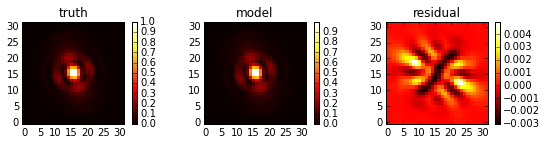

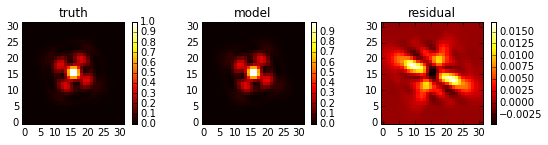

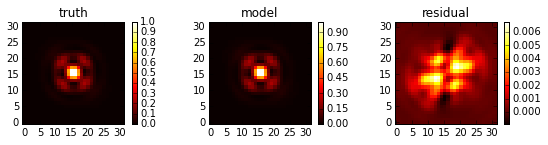

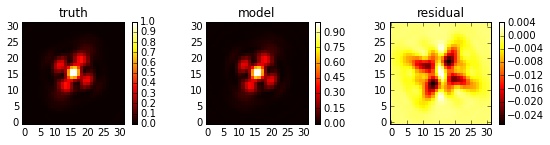

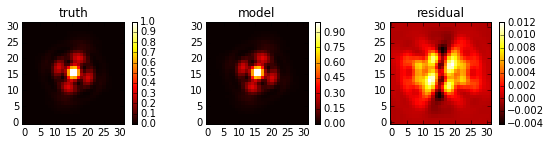

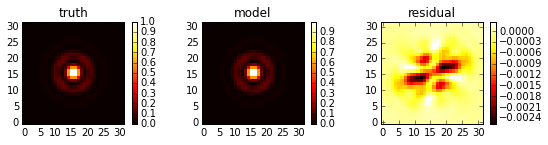

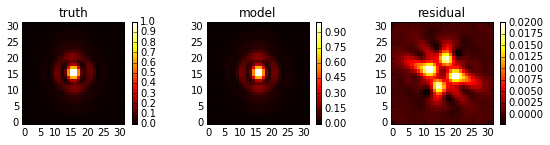

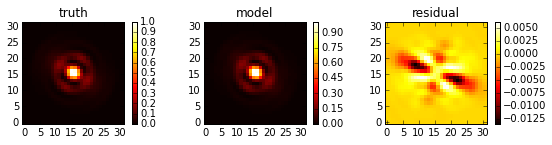

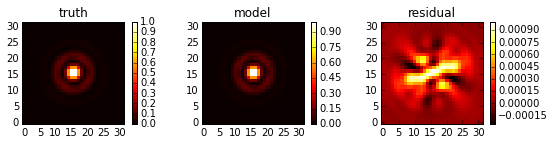

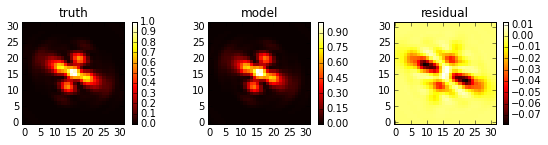

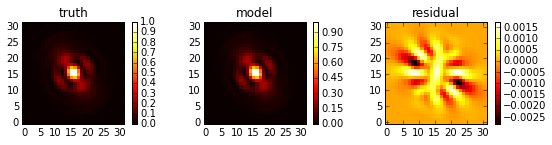

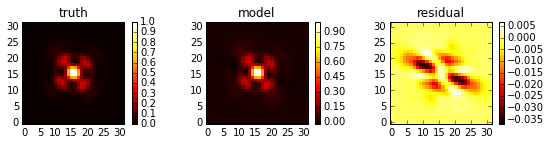

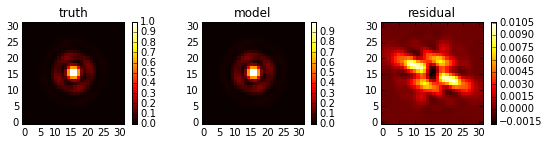

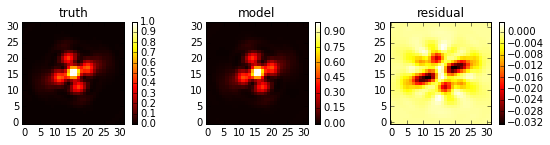

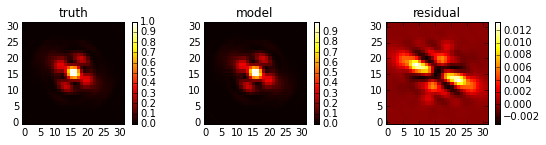

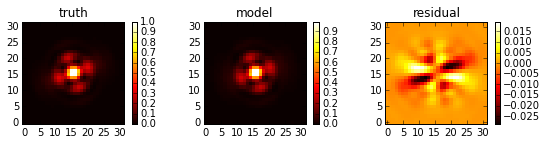

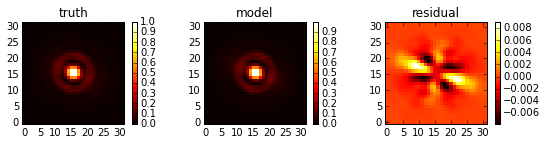

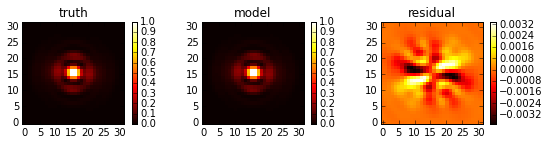

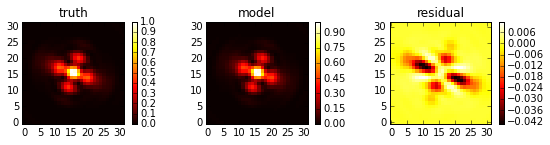

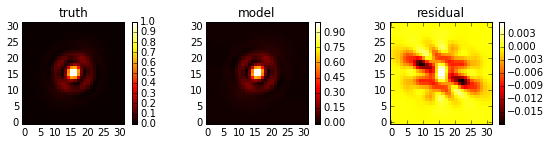

In [10]:
for i in range(20):
    x1 = np.concatenate([x[:i], x[i+1:]])
    Y1 = np.concatenate([Y[:i], Y[i+1:]])
    pipe.fit(x1, Y1)
    Ypred = pipe.predict(x[i])
    Ypred.shape = (32, 32)
    fig = plt.figure(figsize=(8,2))
    ax = fig.add_subplot(1,3,1)
    ax.set_title("truth")
    Ytrue = Y[i].copy()
    Ytrue.shape = (32, 32)
    imtrue = ax.imshow(Ytrue)
    fig.colorbar(imtrue)
    ax = fig.add_subplot(1,3,2)
    ax.set_title("model")
    impred = ax.imshow(Ypred)
    fig.colorbar(impred)
    ax = fig.add_subplot(1,3,3)
    ax.set_title("residual")
    imres = ax.imshow(Ypred - Ytrue)
    fig.colorbar(imres)
    fig.tight_layout()

Roughly 500x speedup, though not perfect accuracy, of course, and only 3 Zernikes at the moment...

In [24]:
timeit pipe.predict(x[0])

1000 loops, best of 3: 224 µs per loop


In [25]:
timeit PSFs[0].drawImage(nx=32, ny=32, scale=0.005)

10 loops, best of 3: 95.5 ms per loop
